<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/KFold_%22LM%2C_Ridge%2C_DT%2C_RF%2C_XGB%2Bneer_cpi_2002_2019%2022.01.2021%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1464]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

!pip install pmdarima -q
#from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima


In [1465]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

# **Переменные**

In [1466]:
cpi = "year"
reg_names = ['NVS']
data_do = "2019-12-01"
train_do = "2018-01-01"

result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'method', 'rmse'])
#result_rmse.append(cpi, reg_names, data_do, train_do, 'method', 'rmse')

In [1467]:
data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)
data.isna().sum().sum()

0

In [1468]:
data.tail(12)

,RF,BEL,BRY,VLA,VOR,IVA,KAL,KOS,KUR,LIP,MOS,ORL,RYA,SMO,TAM,TVE,TUL,YAR,MOW,KAR,KOM,ARK,VLG,KAG,LEN,MUR,NGR,PSK,SPB,ADY,KLM,KRA,AST,VGG,ROS,DAG,ING,KAB,KAO,NOR,STA,BAS,MAR,MOR,TAT,UDM,CHV,PER,KIR,NIZ,ORE,PNZ,SAM,SAR,ULY,KUG,SVE,TYU,CHE,ALI,TUV,KHK,ALT,KYA,IRK,KEM,NVS,OMS,TOM,BUR,ZAB,SAH,KAM,PRI,KHA,AMU,MAG,SAK,JEW,CHU
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-01,103.40,102.67,103.38,103.09,103.36,103.60,102.96,104.14,104.06,103.48,103.71,103.47,102.94,102.29,104.30,102.94,102.47,104.32,103.85,103.34,103.61,103.17,103.04,103.35,103.13,103.98,103.26,102.37,103.12,101.94,104.04,103.09,103.09,102.65,102.91,103.98,103.79,104.17,102.46,102.77,103.70,103.41,103.36,102.26,102.99,102.57,102.47,103.30,102.72,103.41,103.17,102.73,103.35,102.92,103.20,104.22,103.42,102.22,103.33,101.30,103.18,103.83,103.29,103.49,104.30,103.68,102.69,103.57,103.65,104.56,104.11,103.24,103.78,102.97,103.80,105.08,102.37,103.92,105.24,105.06
2019-12-01,102.80,102.33,102.93,101.79,102.34,102.84,102.10,103.48,103.18,102.59,102.90,103.02,101.63,101.51,103.59,102.05,101.76,103.07,103.42,102.60,102.58,102.41,102.61,102.43,102.34,103.19,102.61,101.59,102.55,101.72,103.11,102.34,102.40,102.23,101.99,103.48,103.78,103.42,101.77,101.68,102.77,102.56,102.16,101.72,102.50,102.14,101.65,102.87,102.41,102.62,102.19,102.11,102.63,102.38,102.61,103.35,102.74,102.17,102.94,101.65,102.96,103.13,102.90,103.24,103.90,103.17,101.94,103.08,102.96,103.75,103.84,103.12,103.34,102.94,103.50,105.10,102.16,103.98,104.85,104.78
2020-01-01,102.29,101.66,101.85,101.70,101.84,102.32,101.36,103.08,102.75,102.29,102.13,102.04,101.50,100.93,102.77,101.43,101.06,102.49,102.81,102.16,102.06,102.00,102.26,101.89,102.06,102.88,102.30,101.03,101.95,101.76,102.53,101.86,101.83,101.59,101.68,103.33,103.75,103.01,101.57,101.50,102.32,101.93,101.78,101.12,101.97,101.61,101.58,102.21,102.68,102.41,101.73,101.47,101.89,101.81,101.93,102.81,101.88,101.77,102.59,101.88,102.73,102.61,102.32,102.72,103.79,101.96,101.75,102.40,102.51,103.76,103.65,102.68,103.00,102.89,103.54,105.12,102.10,104.13,104.96,103.42
2020-02-01,102.05,101.60,101.87,101.57,101.78,102.29,101.65,102.98,102.73,102.04,101.83,101.82,101.39,100.94,102.43,101.43,101.19,102.21,102.34,102.20,102.45,102.05,102.14,102.00,101.95,102.57,102.18,100.68,101.65,101.78,101.85,101.67,101.38,101.55,101.71,103.14,103.53,103.01,101.32,100.50,102.59,101.65,101.90,101.04,101.89,101.55,101.17,102.44,102.41,101.68,101.48,101.22,102.18,101.95,101.98,102.52,101.39,101.48,102.21,101.37,102.39,101.93,102.25,102.40,103.25,101.47,101.21,102.14,102.20,103.17,103.17,102.86,102.58,102.96,103.56,105.08,102.95,103.78,104.57,101.66
2020-03-01,102.39,101.86,102.67,102.04,102.58,103.08,101.98,103.60,102.86,102.21,101.90,102.45,101.95,101.61,102.73,101.90,102.08,103.11,102.36,102.63,102.51,102.38,103.07,102.40,102.32,102.96,102.81,101.48,102.23,101.85,102.39,101.96,101.91,102.19,101.87,103.34,103.14,103.25,102.00,101.18,102.93,102.49,102.20,101.79,101.96,102.07,101.49,102.65,103.06,102.37,101.92,102.13,102.28,102.70,102.40,102.96,101.94,101.85,102.87,101.27,102.93,102.13,102.56,102.39,103.34,101.94,101.73,102.42,102.19,103.24,103.74,102.80,102.09,102.64,103.35,105.09,103.65,103.84,104.76,101.05
2020-04-01,103.18,102.77,103.43,102.96,103.73,103.92,103.38,103.94,103.89,103.13,102.63,103.48,103.45,103.39,104.27,103.11,103.32,103.48,102.59,103.38,103.23,103.36,103.72,103.06,103.12,103.88,103.62,102.27,102.87,102.49,103.86,102.85,102.97,103.32,102.82,104.87,104.41,104.33,102.51,102.49,103.34,103.73,103.25,102.49,102.71,102.57,102.89,103.52,104.16,103.43,102.76,103.49,102.97,103.99,103.21,103.90,103.16,102.59,103.72,102.78,103.70,103.38,103.18,103.04,104.06,102.64,102.82,103.06,103.19,103.94,104.71,102.89,102.53,103.71,104.62,105.79,104.02,104.18,106.08,101.33
2020-05-01,103.07,102.95,103.74,102.52,103.67,103.54,103.51,103.79,103.66,103.14,102.80,103.49,103.61,102.99,103.82,103.11,103.24,103.68,102.65,103.46,103.25,103.36,103.

# **Проверка на стационарность**

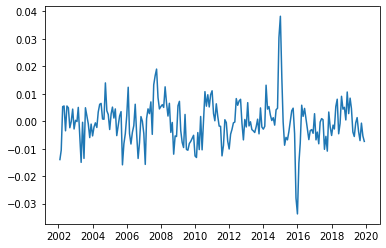

In [1469]:
# to log  and diff
data_st = pd.DataFrame(index = data.index[1:])
#data_st = pd.DataFrame(index = data.index)

for region in data.columns:
#  data_st[region] = np.log(data[region].values)
  data_st[region] = np.diff(np.log(data[region].values))
data_st=(data_st[:-10])

plt.plot(data_st[reg_names])

In [1470]:
"""
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
st = 0
notst = 0
p_value = 0.01
for num, region in enumerate(data_st.keys()):
  if region == 'RF':
    continue
  adf_result = adfuller(data_st[region])
  result_text = []
  result_text.append('ADF: {:.5}, '.format(adf_result[0]))
  result_text.append('p-val: {:.2}, '.format(adf_result[1]))
  if adf_result[1] < float(p_value):
      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      st += 1
  else:
      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))
      notst += 1
print('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\n%matplotlib inline\nst = 0\nnotst = 0\np_value = 0.01\nfor num, region in enumerate(data_st.keys()):\n  if region == 'RF':\n    continue\n  adf_result = adfuller(data_st[region])\n  result_text = []\n  result_text.append('ADF: {:.5}, '.format(adf_result[0]))\n  result_text.append('p-val: {:.2}, '.format(adf_result[1]))\n  if adf_result[1] < float(p_value):\n      print('Регион:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      st += 1\n  else:\n      print('Нестационарный ряд в регионе:', region, 'p-val: {:.2}, '.format(adf_result[1]))\n      notst += 1\nprint('Нестационарных рядов всего:', notst, ' на уровне значимости , ', p_value)\n"

In [1471]:
#if use stationary data
#data=data_st
"""
# для стационарных рядов
data_st = data_st[reg_names]
data_st = data_st[:data_do]
data_st = data_st.merge(course_m, left_on='date', right_on='date')
data_st['month'] = pd.DatetimeIndex(data_st.index).month
train_st = data_st[data_st.index < train_do]
test_st = data_st[data_st.index >= train_do]
"""
# for ML
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')
data['month'] = pd.DatetimeIndex(data.index).month
train = data[data.index < train_do]
test = data[data.index >= train_do]


# **ARIMA**

In [1472]:
exogenous_features = ['month', 'curs']


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=668.032, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=511.942, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=603.384, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=466.953, Time=0.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=527.932, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=468.949, Time=0.55 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=468.950, Time=0.96 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=482.964, Time=0.45 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=470.887, Time=1.55 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=468.881, Time=0.96 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
T

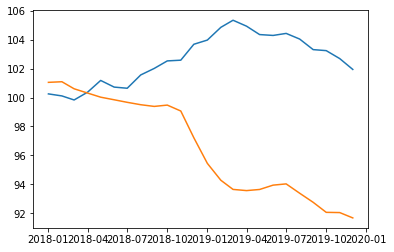

In [1473]:
  # find best params for ARIMA
  stepwise_model = auto_arima (train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, 
                               D=1, d=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

"""  stepwise_model = auto_arima(train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True, \
                              d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, \
                              out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'oob')
  
stepwise_model = auto_arima(train_data['cpi_sfo'], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True,
                           d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
"""

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))


In [1474]:
result = pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])
result

,ARIMA
date,
2018-01-01,101.047390
2018-02-01,101.090124
2018-03-01,100.603229
2018-04-01,100.307508
2018-05-01,100.023016
2018-06-01,99.843606
2018-07-01,99.667476
2018-08-01,99.501990
2018-09-01,99.384945


In [1475]:
mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5

7.713619931265037

In [1476]:
#result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'method', 'rmse'])

result_arima = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ARIMA', 'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arima, ignore_index = True) 

In [1477]:
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.71362


# **ARIMAX**

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=670.642, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=512.194, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=607.148, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=466.815, Time=1.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.00 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=520.478, Time=0.84 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=468.804, Time=1.64 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=468.807, Time=1.44 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=479.903, Time=1.09 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=470.815, Time=1.82 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=468.747, Time=1.85 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
T

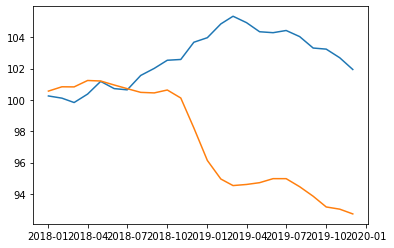

In [1478]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], start_p=1, start_q=1, 
                            max_p=4, max_q=4, m=12, start_P=0, seasonal=True,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [1479]:
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])

In [1480]:
result

,ARIMA,ARIMAX
date,,
2018-01-01,101.047390,100.560175
2018-02-01,101.090124,100.835389
2018-03-01,100.603229,100.828326
2018-04-01,100.307508,101.237493
2018-05-01,100.023016,101.204317
2018-06-01,99.843606,100.950564
2018-07-01,99.667476,100.715555
2018-08-01,99.501990,100.479357
2018-09-01,99.384945,100.444500


In [1481]:
result_arimax = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ARIMAX', 
                'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arimax, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927


# **Feature Engineering**

In [1482]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in {1, 6, 12}:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
    
data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

,curs,t,t-1,t-12,t-6,month
date,,,,,,
2003-01-01,31.816165,110.41,110.37,111.19,109.92,1
2003-02-01,31.698979,110.40,110.41,109.65,110.46,2
2003-03-01,31.453290,110.96,110.40,108.50,110.20,3
2003-04-01,31.211786,110.40,110.96,109.08,110.19,4
2003-05-01,30.907055,108.76,110.40,109.69,110.68,5
...,...,...,...,...,...,...
2019-08-01,65.587483,104.04,104.43,101.56,104.85,8
2019-09-01,64.958705,103.31,104.04,102.01,105.34,9
2019-10-01,64.374991,103.24,103.31,102.53,104.93,10


In [1483]:
df=data_lags
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("date", drop=True, inplace=True)
df.head(12)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,curs,t,t-1,t-12,t-6,month,t_mean_lag3,t_mean_lag6,t_mean_lag12,t_std_lag3,t_std_lag6,t_std_lag12,curs_mean_lag3,curs_mean_lag6,curs_mean_lag12,curs_std_lag3,curs_std_lag6,curs_std_lag12
date,,,,,,,,,,,,,,,,,,
2003-01-01,31.816165,110.41,110.37,111.19,109.92,1,107.403191,107.454636,107.537231,0.608752,1.009354,1.663820,39.286484,39.042568,38.549793,0.986750,1.496779,2.150076
2003-02-01,31.698979,110.40,110.41,109.65,110.46,2,110.410004,110.410004,110.410004,0.608752,1.009354,1.663820,31.816166,31.816166,31.816166,0.986750,1.496779,2.150076
2003-03-01,31.453290,110.96,110.40,108.50,110.20,3,110.404999,110.404999,110.404999,0.007071,0.007071,0.007071,31.757572,31.757572,31.757572,0.082863,0.082863,0.082863
2003-04-01,31.211786,110.40,110.96,109.08,110.19,4,110.589996,110.589996,110.589996,0.320468,0.320468,0.320468,31.656145,31.656145,31.656145,0.185191,0.185191,0.185191
2003-05-01,30.907055,108.76,110.40,109.69,110.68,5,110.586670,110.542503,110.542503,0.323316,0.278373,0.278373,31.454685,31.545055,31.545055,0.243599,0.268751,0.268751
2003-06-01,30.468626,108.72,108.76,109.31,110.37,6,110.040001,110.185997,110.185997,1.143328,0.832815,0.832815,31.190710,31.417456,31.417456,0.273727,0.368211,0.368211
2003-07-01,30.360287,107.26,108.72,109.92,110.41,7,109.293335,109.941666,109.941666,0.958610,0.955540,0.955540,30.862490,31.259317,31.259317,0.373579,0.508438,0.508438
2003-08-01,30.349027,107.79,107.26,110.46,110.40,8,108.246666,109.416664,109.558571,0.854712,1.405954,1.337241,30.578655,31.016670,31.130884,0.289515,0.536183,0.575230
2003-09-01,30.598633,108.01,107.79,110.20,110.96,9,107.923332,108.981667,109.337502,0.739076,1.444111,1.386988,30.392647,30.791679,31.033152,0.066041,0.472003,0.600027


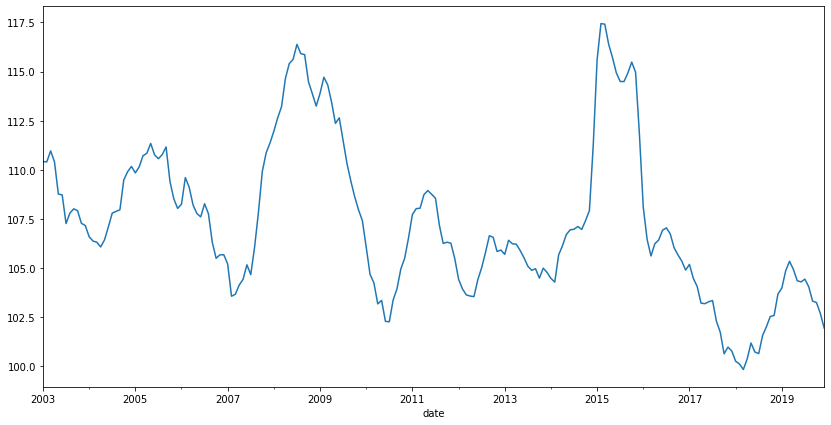

In [1484]:
df.t.plot(figsize=(14, 7))

In [1485]:
data = df
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

"""
X_train = train.values
y_train = train[['t']].values.ravel()
X_test = test.values
y_test = test[['t']].values.ravel()
"""
X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()


In [1486]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])
result

,ARIMA,ARIMAX,y_test
date,,,
2018-01-01,101.047390,100.560175,100.25
2018-02-01,101.090124,100.835389,100.11
2018-03-01,100.603229,100.828326,99.83
2018-04-01,100.307508,101.237493,100.37
2018-05-01,100.023016,101.204317,101.18
2018-06-01,99.843606,100.950564,100.72
2018-07-01,99.667476,100.715555,100.64
2018-08-01,99.501990,100.479357,101.56
2018-09-01,99.384945,100.444500,102.01


# **KNeighborsRegressor**

In [1487]:
!pip install mglearn -q

In [1488]:
from sklearn.datasets import make_blobs
import mglearn
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=20)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.73
Test set score: -0.83
rmse: 2.2901
normed rmse: 2.2316%


In [1489]:
result['KNR']=pd.DataFrame(np.array(forecast), index = test.index, columns=['KNR'])

In [1490]:
result

,ARIMA,ARIMAX,y_test,KNR
date,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085
2018-02-01,101.090124,100.835389,100.11,104.1085
2018-03-01,100.603229,100.828326,99.83,104.1085
2018-04-01,100.307508,101.237493,100.37,104.5675
2018-05-01,100.023016,101.204317,101.18,104.1085
2018-06-01,99.843606,100.950564,100.72,104.1085
2018-07-01,99.667476,100.715555,100.64,104.1085
2018-08-01,99.501990,100.479357,101.56,104.1085
2018-09-01,99.384945,100.444500,102.01,104.1085


In [1491]:
result_KNR = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'KNR', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_KNR, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064


# **OLS**

In [1492]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

forecast = lr.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.86
rmse: 0.6290
normed rmse: 0.6129%


In [1493]:
result['OLS']=pd.DataFrame(np.array(forecast), index = test.index, columns=['OLS'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS
date,,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085,100.839379
2018-02-01,101.090124,100.835389,100.11,104.1085,100.182309
2018-03-01,100.603229,100.828326,99.83,104.1085,100.147266
2018-04-01,100.307508,101.237493,100.37,104.5675,100.158584
2018-05-01,100.023016,101.204317,101.18,104.1085,101.258287
2018-06-01,99.843606,100.950564,100.72,104.1085,102.201604
2018-07-01,99.667476,100.715555,100.64,104.1085,100.946503
2018-08-01,99.501990,100.479357,101.56,104.1085,100.669179
2018-09-01,99.384945,100.444500,102.01,104.1085,102.476917


In [1494]:
result_OLS = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'OLS', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_OLS, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064
3,year,[NVS],2019-12-01,2018-01-01,OLS,0.628951


# **Ridge (l2-regularisation)**

In [1495]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

forecast = ridge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.87
rmse: 0.62020
normed rmse: 0.60%


In [1496]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.87
rmse: 0.61110
normed rmse: 0.60%


In [1497]:
ridge01 = Ridge(alpha=0.001).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

forecast = ridge01.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.96984
Test set score: 0.86
rmse: 0.62894
normed rmse: 0.61%


In [1498]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge
date,,,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085,100.839379,100.839374
2018-02-01,101.090124,100.835389,100.11,104.1085,100.182309,100.182422
2018-03-01,100.603229,100.828326,99.83,104.1085,100.147266,100.147352
2018-04-01,100.307508,101.237493,100.37,104.5675,100.158584,100.158504
2018-05-01,100.023016,101.204317,101.18,104.1085,101.258287,101.258277
2018-06-01,99.843606,100.950564,100.72,104.1085,102.201604,102.201592
2018-07-01,99.667476,100.715555,100.64,104.1085,100.946503,100.946523
2018-08-01,99.501990,100.479357,101.56,104.1085,100.669179,100.669179
2018-09-01,99.384945,100.444500,102.01,104.1085,102.476917,102.476757


In [1499]:
result_Ridge = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'Ridge', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Ridge, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064
3,year,[NVS],2019-12-01,2018-01-01,OLS,0.628951
4,year,[NVS],2019-12-01,2018-01-01,Ridge,0.628936


# **Lasso (l1-regularisation)**

In [1500]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

forecast = lasso.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.94
Test set score: 0.89
Number of features used: 3
rmse: 0.5545
normed rmse: 0.54%


In [1501]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.97
Test set score: 0.90
Number of features used: 14
rmse: 0.54896
normed rmse: 0.53%


In [1502]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso
date,,,,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085,100.839379,100.839374,100.784714
2018-02-01,101.090124,100.835389,100.11,104.1085,100.182309,100.182422,100.319177
2018-03-01,100.603229,100.828326,99.83,104.1085,100.147266,100.147352,100.273676
2018-04-01,100.307508,101.237493,100.37,104.5675,100.158584,100.158504,100.039061
2018-05-01,100.023016,101.204317,101.18,104.1085,101.258287,101.258277,101.168626
2018-06-01,99.843606,100.950564,100.72,104.1085,102.201604,102.201592,102.116241
2018-07-01,99.667476,100.715555,100.64,104.1085,100.946503,100.946523,100.855023
2018-08-01,99.501990,100.479357,101.56,104.1085,100.669179,100.669179,100.590579
2018-09-01,99.384945,100.444500,102.01,104.1085,102.476917,102.476757,102.200380


In [1503]:
result_Lasso = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'Lasso', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Lasso, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064
3,year,[NVS],2019-12-01,2018-01-01,OLS,0.628951
4,year,[NVS],2019-12-01,2018-01-01,Ridge,0.628936
5,year,[NVS],2019-12-01,2018-01-01,Lasso,0.548962


# **ElasticNet (l1+l2-regularisation)**

In [1504]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.96
Test set score: 0.91
Number of features used: 11
rmse: 0.49601
normed rmse: 0.48%


In [1505]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet
date,,,,,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085,100.839379,100.839374,100.784714,100.746132
2018-02-01,101.090124,100.835389,100.11,104.1085,100.182309,100.182422,100.319177,100.424857
2018-03-01,100.603229,100.828326,99.83,104.1085,100.147266,100.147352,100.273676,100.336869
2018-04-01,100.307508,101.237493,100.37,104.5675,100.158584,100.158504,100.039061,100.056467
2018-05-01,100.023016,101.204317,101.18,104.1085,101.258287,101.258277,101.168626,101.015291
2018-06-01,99.843606,100.950564,100.72,104.1085,102.201604,102.201592,102.116241,101.909905
2018-07-01,99.667476,100.715555,100.64,104.1085,100.946503,100.946523,100.855023,101.058266
2018-08-01,99.501990,100.479357,101.56,104.1085,100.669179,100.669179,100.590579,100.887953
2018-09-01,99.384945,100.444500,102.01,104.1085,102.476917,102.476757,102.200380,102.126106


In [1506]:
result_ElasticNet = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'ElasticNet', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064
3,year,[NVS],2019-12-01,2018-01-01,OLS,0.628951
4,year,[NVS],2019-12-01,2018-01-01,Ridge,0.628936
5,year,[NVS],2019-12-01,2018-01-01,Lasso,0.548962
6,year,[NVS],2019-12-01,2018-01-01,ElasticNet,0.496008


# **DecisionTree**

In [1507]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

forecast = tree.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Accuracy on training set: 0.882
Accuracy on test set: -0.607
rmse: 2.14834
normed rmse: 2.09%


In [1508]:
result['DecisionTree']=pd.DataFrame(np.array(forecast), index = test.index, columns=['DecisionTree'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree
date,,,,,,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085,100.839379,100.839374,100.784714,100.746132,103.938696
2018-02-01,101.090124,100.835389,100.11,104.1085,100.182309,100.182422,100.319177,100.424857,103.938696
2018-03-01,100.603229,100.828326,99.83,104.1085,100.147266,100.147352,100.273676,100.336869,103.938696
2018-04-01,100.307508,101.237493,100.37,104.5675,100.158584,100.158504,100.039061,100.056467,103.938696
2018-05-01,100.023016,101.204317,101.18,104.1085,101.258287,101.258277,101.168626,101.015291,103.938696
2018-06-01,99.843606,100.950564,100.72,104.1085,102.201604,102.201592,102.116241,101.909905,103.938696
2018-07-01,99.667476,100.715555,100.64,104.1085,100.946503,100.946523,100.855023,101.058266,103.938696
2018-08-01,99.501990,100.479357,101.56,104.1085,100.669179,100.669179,100.590579,100.887953,103.938696
2018-09-01,99.384945,100.444500,102.01,104.1085,102.476917,102.476757,102.200380,102.126106,103.938696


In [1509]:
result_DT = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'DT', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_DT, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064
3,year,[NVS],2019-12-01,2018-01-01,OLS,0.628951
4,year,[NVS],2019-12-01,2018-01-01,Ridge,0.628936
5,year,[NVS],2019-12-01,2018-01-01,Lasso,0.548962
6,year,[NVS],2019-12-01,2018-01-01,ElasticNet,0.496008
7,year,[NVS],2019-12-01,2018-01-01,DT,2.148343


# **Random Forest**

rmse: 0.95725
normed rmse: 0.933%
Accuracy on training set: 0.991
Accuracy on test set: 0.681


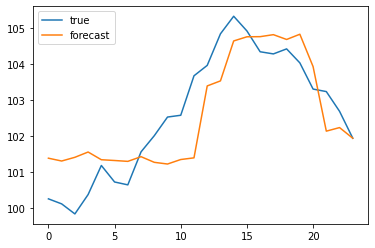

In [1510]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=500, random_state=42)
RFmodel.fit(X_train, y_train)
forecast = RFmodel.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.3f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(RFmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RFmodel.score(X_test, y_test)))

In [1511]:
result['Random Forest']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Random Forest'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree,Random Forest
date,,,,,,,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085,100.839379,100.839374,100.784714,100.746132,103.938696,101.38310
2018-02-01,101.090124,100.835389,100.11,104.1085,100.182309,100.182422,100.319177,100.424857,103.938696,101.30450
2018-03-01,100.603229,100.828326,99.83,104.1085,100.147266,100.147352,100.273676,100.336869,103.938696,101.40812
2018-04-01,100.307508,101.237493,100.37,104.5675,100.158584,100.158504,100.039061,100.056467,103.938696,101.55546
2018-05-01,100.023016,101.204317,101.18,104.1085,101.258287,101.258277,101.168626,101.015291,103.938696,101.34032
2018-06-01,99.843606,100.950564,100.72,104.1085,102.201604,102.201592,102.116241,101.909905,103.938696,101.31890
2018-07-01,99.667476,100.715555,100.64,104.1085,100.946503,100.946523,100.855023,101.058266,103.938696,101.29462
2018-08-01,99.501990,100.479357,101.56,104.1085,100.669179,100.669179,100.590579,100.887953,103.938696,101.42548
2018-09-01,99.384945,100.444500,102.01,104.1085,102.476917,102.476757,102.200380,102.126106,103.938696,101.26800


In [1512]:
result_RF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RF', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RF, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064
3,year,[NVS],2019-12-01,2018-01-01,OLS,0.628951
4,year,[NVS],2019-12-01,2018-01-01,Ridge,0.628936
5,year,[NVS],2019-12-01,2018-01-01,Lasso,0.548962
6,year,[NVS],2019-12-01,2018-01-01,ElasticNet,0.496008
7,year,[NVS],2019-12-01,2018-01-01,DT,2.148343
8,year,[NVS],2019-12-01,2018-01-01,RF,0.957253


In [1513]:
RFmodel.feature_importances_

array([0.00214752, 0.9294962 , 0.00833096, 0.00471787, 0.00388405,
       0.00396959, 0.00253513, 0.00685403, 0.00279803, 0.00479101,
       0.01172187, 0.00208345, 0.00205345, 0.0029205 , 0.00308752,
       0.00389301, 0.00471582])

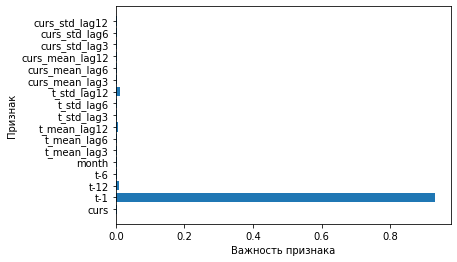

In [1514]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(RFmodel)

# **Кроссвалидация**

In [1515]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RFmodel, X_train, y_train, cv=3)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.75680401 0.78345465 0.82478164]
Average cross-validation score: 0.79


In [1516]:
from sklearn.model_selection import cross_validate
res = cross_validate(RFmodel, X_train, y_train, cv=4,
                     return_train_score=True)
display(res)

{'fit_time': array([0.90411186, 0.88976574, 0.90220904, 0.88596845]),
 'score_time': array([0.03697729, 0.03578544, 0.0301125 , 0.02839422]),
 'test_score': array([0.53083488, 0.78020388, 0.68559405, 0.81384818]),
 'train_score': array([0.99161985, 0.98862873, 0.99142912, 0.99381835])}

In [1517]:
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.904112,0.036977,0.530835,0.991620
1,0.889766,0.035785,0.780204,0.988629
2,0.902209,0.030113,0.685594,0.991429
3,0.885968,0.028394,0.813848,0.993818


Mean times and scores:
 fit_time       0.895514
score_time     0.032817
test_score     0.702620
train_score    0.991374
dtype: float64


# **Slide test**

In [1518]:
"""
from datetime import datetime
from dateutil.relativedelta import relativedelta
#startdate = pd.to_datetime(data_do)
startdate = pd.to_datetime(train_do)+ relativedelta(months=1)

#print('Today: ', startdate.strftime('%Y-%m-%d'))
#print(date_after_month.strftime('%Y-%m-%d'))
#startdate = str(startdate)[:10]
startdate
"""

"\nfrom datetime import datetime\nfrom dateutil.relativedelta import relativedelta\n#startdate = pd.to_datetime(data_do)\nstartdate = pd.to_datetime(train_do)+ relativedelta(months=1)\n\n#print('Today: ', startdate.strftime('%Y-%m-%d'))\n#print(date_after_month.strftime('%Y-%m-%d'))\n#startdate = str(startdate)[:10]\nstartdate\n"

In [1519]:
"""
#forecast = RFmodel.predict(X_test)
#slide_test = test[test.index == train_do][data_not.columns.values].values
#print(slide_test)
slide_test = X_test
forecast = []
forecast.append(RFmodel.predict(slide_test)[0])

for i in range(test.shape[0] - 1):
  
  slide_test_next = slide_test.copy()
  slide_test_next[0, 1] = forecast[-1]

  slide_test_next[0, 0] += 1
  slide_test_next[0, 2:] = slide_test[0, 1:-1]
  
  #print(slide_test_next)
  slide_test = slide_test_next.copy()

  forecast.append(RFmodel.predict(slide_test)[0])

forecast = np.array(forecast)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))
"""

"\n#forecast = RFmodel.predict(X_test)\n#slide_test = test[test.index == train_do][data_not.columns.values].values\n#print(slide_test)\nslide_test = X_test\nforecast = []\nforecast.append(RFmodel.predict(slide_test)[0])\n\nfor i in range(test.shape[0] - 1):\n  \n  slide_test_next = slide_test.copy()\n  slide_test_next[0, 1] = forecast[-1]\n\n  slide_test_next[0, 0] += 1\n  slide_test_next[0, 2:] = slide_test[0, 1:-1]\n  \n  #print(slide_test_next)\n  slide_test = slide_test_next.copy()\n\n  forecast.append(RFmodel.predict(slide_test)[0])\n\nforecast = np.array(forecast)\n\nplt.plot(y_test, label='true')\nplt.plot(forecast, label='forecast')\nplt.legend()\n\nprint('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))\nprint('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))\n"

In [1520]:
"""result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_RFST, ignore_index = True) 
result_rmse
"""

"result_RFST = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'RFST', \n                'rmse': mean_squared_error(y_test, forecast) ** 0.5} \nresult_rmse = result_rmse.append(result_RFST, ignore_index = True) \nresult_rmse\n"

# **KFold cross validation**

In [1521]:
#!pip install mglearn -q
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import mglearn


In [1522]:
%%time
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1)
#model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.65806154 0.8770768  0.90206799 0.69860607 0.83126565]
CPU times: user 447 ms, sys: 5.9 ms, total: 453 ms
Wall time: 459 ms


In [1523]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.79


# **Stratified K-Fold cross-validation and other strategies**

In [1524]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)

In [1525]:
print("Cross-validation scores:\n{}".format(
      cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[0.74849999 0.77850819 0.83564764]


In [1526]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
print("Cross-validation scores:\n{}".format(
    cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[0.91204942 0.90586463 0.93418446]


# **GradientBoostingRegressor**

In [1527]:
from xgboost import XGBRegressor

[10:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 0.8622
normed rmse: 0.8402%
Accuracy on training set: 0.987
Accuracy on test set: 0.741


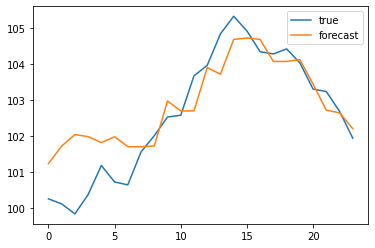

In [1562]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=2)
xgb_model.fit(X_train, y_train, verbose=False)
# make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_model.feature_importances_
plt.plot(y_test, label='true')
plt.plot(xgb_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, xgb_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, xgb_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

In [1529]:
result['GradientBoosting']=pd.DataFrame(np.array(xgb_forecast), index = test.index, columns=['GradientBoosting'])
result

,ARIMA,ARIMAX,y_test,KNR,OLS,Ridge,Lasso,ElasticNet,DecisionTree,Random Forest,GradientBoosting
date,,,,,,,,,,,
2018-01-01,101.047390,100.560175,100.25,104.1085,100.839379,100.839374,100.784714,100.746132,103.938696,101.38310,101.049698
2018-02-01,101.090124,100.835389,100.11,104.1085,100.182309,100.182422,100.319177,100.424857,103.938696,101.30450,101.741295
2018-03-01,100.603229,100.828326,99.83,104.1085,100.147266,100.147352,100.273676,100.336869,103.938696,101.40812,101.956139
2018-04-01,100.307508,101.237493,100.37,104.5675,100.158584,100.158504,100.039061,100.056467,103.938696,101.55546,102.318115
2018-05-01,100.023016,101.204317,101.18,104.1085,101.258287,101.258277,101.168626,101.015291,103.938696,101.34032,101.816833
2018-06-01,99.843606,100.950564,100.72,104.1085,102.201604,102.201592,102.116241,101.909905,103.938696,101.31890,102.322449
2018-07-01,99.667476,100.715555,100.64,104.1085,100.946503,100.946523,100.855023,101.058266,103.938696,101.29462,101.656731
2018-08-01,99.501990,100.479357,101.56,104.1085,100.669179,100.669179,100.590579,100.887953,103.938696,101.42548,101.592323
2018-09-01,99.384945,100.444500,102.01,104.1085,102.476917,102.476757,102.200380,102.126106,103.938696,101.26800,101.319328


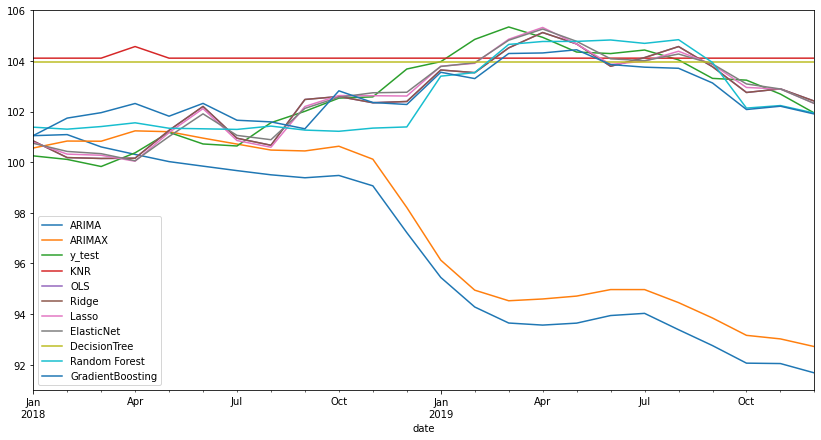

In [1530]:
result.plot(figsize=(14, 7))

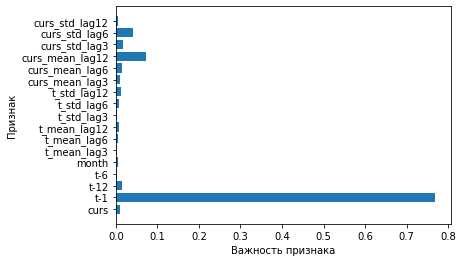

In [1531]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(xgb_model)

# **Results**

In [1532]:
result_XGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'method': 'XGB', 
                'rmse': mean_squared_error(y_test, xgb_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_XGB, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,method,rmse
0,year,[NVS],2019-12-01,2018-01-01,ARIMA,7.713620
1,year,[NVS],2019-12-01,2018-01-01,ARIMAX,6.950927
2,year,[NVS],2019-12-01,2018-01-01,KNR,2.290064
3,year,[NVS],2019-12-01,2018-01-01,OLS,0.628951
4,year,[NVS],2019-12-01,2018-01-01,Ridge,0.628936
5,year,[NVS],2019-12-01,2018-01-01,Lasso,0.548962
6,year,[NVS],2019-12-01,2018-01-01,ElasticNet,0.496008
7,year,[NVS],2019-12-01,2018-01-01,DT,2.148343
8,year,[NVS],2019-12-01,2018-01-01,RF,0.957253
9,year,[NVS],2019-12-01,2018-01-01,XGB,1.012798


In [1533]:
"""
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

print("Cross-validation scores:\n{}".format(
      cross_val_score(xgb_model, X_train, y_train, cv=kfold)))


kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
      cross_val_score(xgb_model, X_train, y_train, cv=kfold)))

kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(xgb_model, X_train, y_train, cv=kfold)))
"""

'\nfrom sklearn.model_selection import KFold\nkfold = KFold(n_splits=5)\n\nprint("Cross-validation scores:\n{}".format(\n      cross_val_score(xgb_model, X_train, y_train, cv=kfold)))\n\n\nkfold = KFold(n_splits=3)\nprint("Cross-validation scores:\n{}".format(\n      cross_val_score(xgb_model, X_train, y_train, cv=kfold)))\n\nkfold = KFold(n_splits=3, shuffle=True, random_state=0)\nprint("Cross-validation scores:\n{}".format(\n    cross_val_score(xgb_model, X_train, y_train, cv=kfold)))\n'

# **Grid Search**

In [1534]:
param_grid = {'max_depth': [1, 2, 3, 50, 100],
              'n_estimators': [1, 10, 50, 100, 500]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'max_depth': [1, 2, 3, 50, 100], 'n_estimators': [1, 10, 50, 100, 500]}


In [1535]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 50, 100],
                         'n_estimators': [1, 10, 50, 100, 500]},
         

In [1536]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.56
Best parameters: {'max_depth': 1, 'n_estimators': 100}
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [1537]:
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006859,0.001218,0.001239,0.000344,1,1,"{'max_depth': 1, 'n_estimators': 1}",-3590.177109,-589.660002,-798.002024,-4132.004310,-318.810368,-1885.730763,1629.053403,21,-558.906711,-724.746264,-639.530690,-610.806559,-914.940771,-689.786199,124.747447
1,0.006246,0.000261,0.000850,0.000044,1,10,"{'max_depth': 1, 'n_estimators': 10}",-566.122687,-95.048570,-120.113976,-571.856241,-48.803141,-280.388923,236.756441,16,-85.053566,-110.290791,-97.322761,-92.951612,-139.234220,-104.970590,18.983855
2,0.010111,0.000128,0.000885,0.000017,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.613901,0.799591,0.913699,0.607529,0.798577,0.746659,0.118644,11,0.917307,0.897115,0.908033,0.910929,0.897025,0.906082,0.007947
3,0.015912,0.001343,0.000904,0.000023,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.797773,0.895020,0.901895,0.707925,0.869128,0.834348,0.073176,1,0.973890,0.970871,0.973833,0.974664,0.970360,0.972724,0.001754
4,0.062338,0.005771,0.001206,0.000096,1,500,"{'max_depth': 1, 'n_estimators': 500}",0.766321,0.917173,0.883629,0.687298,0.754341,0.801752,0.085590,3,0.992223,0.991592,0.991948,0.991746,0.990239,0.991550,0.000689


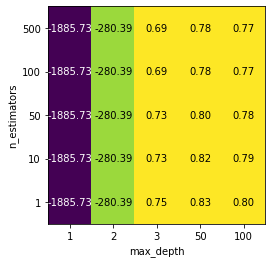

In [1538]:
scores = np.array(results.mean_test_score).reshape(5, 5)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='max_depth', xticklabels=param_grid['max_depth'],
                      ylabel='n_estimators', yticklabels=param_grid['n_estimators'], cmap="viridis")

In [1539]:
"""
# naive grid search implementation
best_score = 0

for max_depth in [3, 5, 10, 100]:
    for learning_rate in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train 
        xgb_model = XGBRegressor (n_estimators=10000, learning_rate=learning_rate, max_depth=max_depth)
        xgb_model.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = xgb_model.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': max_depth, 'learning_rate': learning_rate}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))
"""

'\n# naive grid search implementation\nbest_score = 0\n\nfor max_depth in [3, 5, 10, 100]:\n    for learning_rate in [0.001, 0.01, 0.1, 1, 10, 100]:\n        # for each combination of parameters, train \n        xgb_model = XGBRegressor (n_estimators=10000, learning_rate=learning_rate, max_depth=max_depth)\n        xgb_model.fit(X_train, y_train)\n        # evaluate the SVC on the test set\n        score = xgb_model.score(X_test, y_test)\n        # if we got a better score, store the score and parameters\n        if score > best_score:\n            best_score = score\n            best_parameters = {\'max_depth\': max_depth, \'learning_rate\': learning_rate}\n\nprint("Best score: {:.2f}".format(best_score))\nprint("Best parameters: {}".format(best_parameters))\n'